In [1]:
import os

import subprocess
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel
import torch

import umap
import hdbscan
from hdbscan.flat import (HDBSCAN_flat,
						  approximate_predict_flat,
						  membership_vector_flat,
						  all_points_membership_vectors_flat)

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# PLOT CLUSTERS
import matplotlib.pyplot as plt
import pandas as pd

/home/arise/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_projects (path):
	command = f"ls {path}"
	result = subprocess.run(command, shell=True, capture_output=True, text=True)

	if result.returncode == 0:
		file_list = result.stdout.splitlines()
		return file_list
	else:
		print("Error: ", result.stderr)

def get_data (path):
	command = f"cat {path}"
	result = subprocess.run(command, shell=True, capture_output=True, text=True)

	if result.returncode == 0:
		lines = result.stdout.splitlines()
		return lines
	else:
		print("Error: ", result.stderr)

def embed_data (projects, data_list, tokenizer, model, device):
  initial_tensor = torch.empty(0, 768)
  initial_list = []

  for i in range(len(projects)):
    print("*****["+projects[i]+"]*****")
    for j in tqdm(range(5000)):
      code_tokens = tokenizer.tokenize(data_list[i][j])
      tokens = [tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
      tokens_ids = tokenizer.convert_tokens_to_ids(tokens)

      if (len(tokens_ids) > 511):
        continue
      
      # Perform gradient checkpointing during the forward pass
      with torch.no_grad():
        context_embeddings = model(torch.tensor(tokens_ids).to(device)[None,:])[0][:,0,:]

      # context_embeddings = model(torch.tensor(tokens_ids).to(device)[None,:])[0][:,0,:]
      initial_tensor = torch.cat((initial_tensor, context_embeddings.cpu()), dim=0)
      initial_list.append(data_list[i][j])

      # release tensor
      del context_embeddings
      torch.cuda.empty_cache()
    
  return initial_tensor, initial_list

In [3]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [4]:
def plot(embeddings, data_list, n_neighbors, n_components=5, min_dist=0.0, min_cluster_size=5, min_samples=5, title="none"):
	# REDUCE EMBEDDING DIMENSIONS using UMAP
	umap_embeddings = umap.UMAP(n_neighbors=n_neighbors,
                              n_components=n_components,
                              min_dist=min_dist,
                              metric='cosine').fit_transform(embeddings)
	print('\ndone with reducing dimension')


	# ------------------------------------------------------------------------


	# CLUSTER EMBEDDINGS using HDBSCAN
	'''
	does not force data points meaning knows outliers
	'''
	cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            min_samples=min_samples,
                            cluster_selection_epsilon=0.0,
                            metric='euclidean',
                            cluster_selection_method='eom').fit(umap_embeddings)
	'''
	cluster = HDBSCAN_flat(umap_embeddings,
							cluster_selection_method='eom',
							n_clusters=20,
							min_cluster_size=min_cluster_size)
	'''	

	print('\ndone with clustering')


	# ------------------------------------------------------------------------


	# Prepare data
	umap_data = umap.UMAP(n_neighbors=n_neighbors,
                        n_components=2,
                        min_dist=min_dist,
                        metric='cosine').fit_transform(embeddings)
	result = pd.DataFrame(umap_data, columns=['x', 'y'])
	result['labels'] = cluster.labels_


	# ------------------------------------------------------------------------


	# Visualize clusters
	fig, ax = plt.subplots(figsize=(20, 10))
	outliers = result.loc[result.labels == -1, :]
	clustered = result.loc[result.labels != -1, :]
	plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
	plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
	plt.colorbar()
	plt.show()

	print('\ndone with plot')


	# ------------------------------------------------------------------------


	#c-TF-IDF
	docs_df = pd.DataFrame(data_list, columns=["Doc"])
	docs_df['Topic'] = cluster.labels_
	docs_df['Doc_ID'] = range(len(docs_df))
	docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


	  
	tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data_list))



	top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
	topic_sizes = extract_topic_sizes(docs_df);

	print(title)
	print('n_neighbers: ' + str(n_neighbors))
	print('n_components: ' + str(n_components))
	print('min_dist: ' + str(min_dist))
	print('min_cluster_size: ' + str(min_cluster_size))
	print('min_samples: ' + str(min_samples))

	print(topic_sizes.head(10))
	print(len(topic_sizes))


	cnt = 0
	for i, row in topic_sizes.iterrows():
		topic_num = row['Topic']
		topic_size = row['Size']

		if topic_num == -1: continue

		print(topic_size, top_n_words[topic_num][:10])

		if cnt == 10: break
		cnt += 1
	
	return docs_per_topic, top_n_words, topic_sizes

In [5]:
def create_directory(directory_path):
	if not os.path.exists(directory_path):
		os.makedirs(directory_path)
		print(f"Directory created: {directory_path}")
	else:
		print(f"Directory already exists: {directory_path}")

def write_results(topic_sizes, top_n_words, chng_neigh):
    dir = '../results/'
    create_directory(dir)

    fn = chng_neigh[5]

    with open(dir + fn, 'w') as f:
        f.write('n_neighbers: ' + str(chng_neigh[0]) + '\n')
        f.write('n_components: ' + str(chng_neigh[1]) + '\n')
        f.write('min_dist: ' + str(chng_neigh[2]) + '\n')
        f.write('min_cluster_size: ' + str(chng_neigh[3]) + '\n\n')
        f.write('min_samples: ' + str(chng_neigh[4]) + '\n\n')

        total = str(topic_sizes['Size'].sum())
        nonCluster = str(topic_sizes['Size'][0])
        cluter_n = str(len(topic_sizes))

        f.write('total number of cluster: ' + cluter_n + '\n')
        f.write('not in cluster: ' + nonCluster + '/' + total + '\n\n')
        f.write('top 5 cluster')

        cnt = 0
        for i, row in topic_sizes.iterrows():
            f.write('\n')
            topic_num = row['Topic']
            topic_size = row['Size']

            if topic_num == -1: continue

            f.write('cluster #' + str(topic_num) + '\n')
            f.write('cluster size: ' + str(topic_size) + '\n')

            for word in top_n_words[topic_num][:10]:
                f.write(str(word) + '\n')
            f.write('\n')

            if cnt == 10: break
            cnt += 1

            f.write('\n')

In [6]:
# ***** get lists of projects *****
data_path = "../data/"
projects = get_projects(data_path)

# ***** get data for each projects *****
data_list = []
for project in projects:
	full_path = data_path + project
	data_list.append( get_data(full_path) )

# ***** bring CodeBert Model *****
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to(device) # RobertaModel

# ***** tokenize and embed data *****
embeddings, data_list = embed_data(projects, data_list, tokenizer, model, device)

*****[curl]*****


100%|██████████| 5000/5000 [00:38<00:00, 131.48it/s]


*****[gdal]*****


100%|██████████| 5000/5000 [00:52<00:00, 94.83it/s] 


*****[grok]*****


100%|██████████| 5000/5000 [01:10<00:00, 70.93it/s]


*****[leptonica]*****


100%|██████████| 5000/5000 [01:24<00:00, 59.06it/s]


*****[libxml2]*****


100%|██████████| 5000/5000 [01:35<00:00, 52.24it/s]


*****[openh264]*****


100%|██████████| 5000/5000 [01:50<00:00, 45.23it/s]


*****[openssl]*****


100%|██████████| 5000/5000 [02:01<00:00, 41.23it/s]


*****[poppler]*****


100%|██████████| 5000/5000 [02:13<00:00, 37.50it/s]


*****[usrsctp]*****


100%|██████████| 5000/5000 [02:22<00:00, 35.14it/s]


*****[zstd]*****


100%|██████████| 5000/5000 [02:34<00:00, 32.38it/s]



done with reducing dimension

done with clustering


/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spe

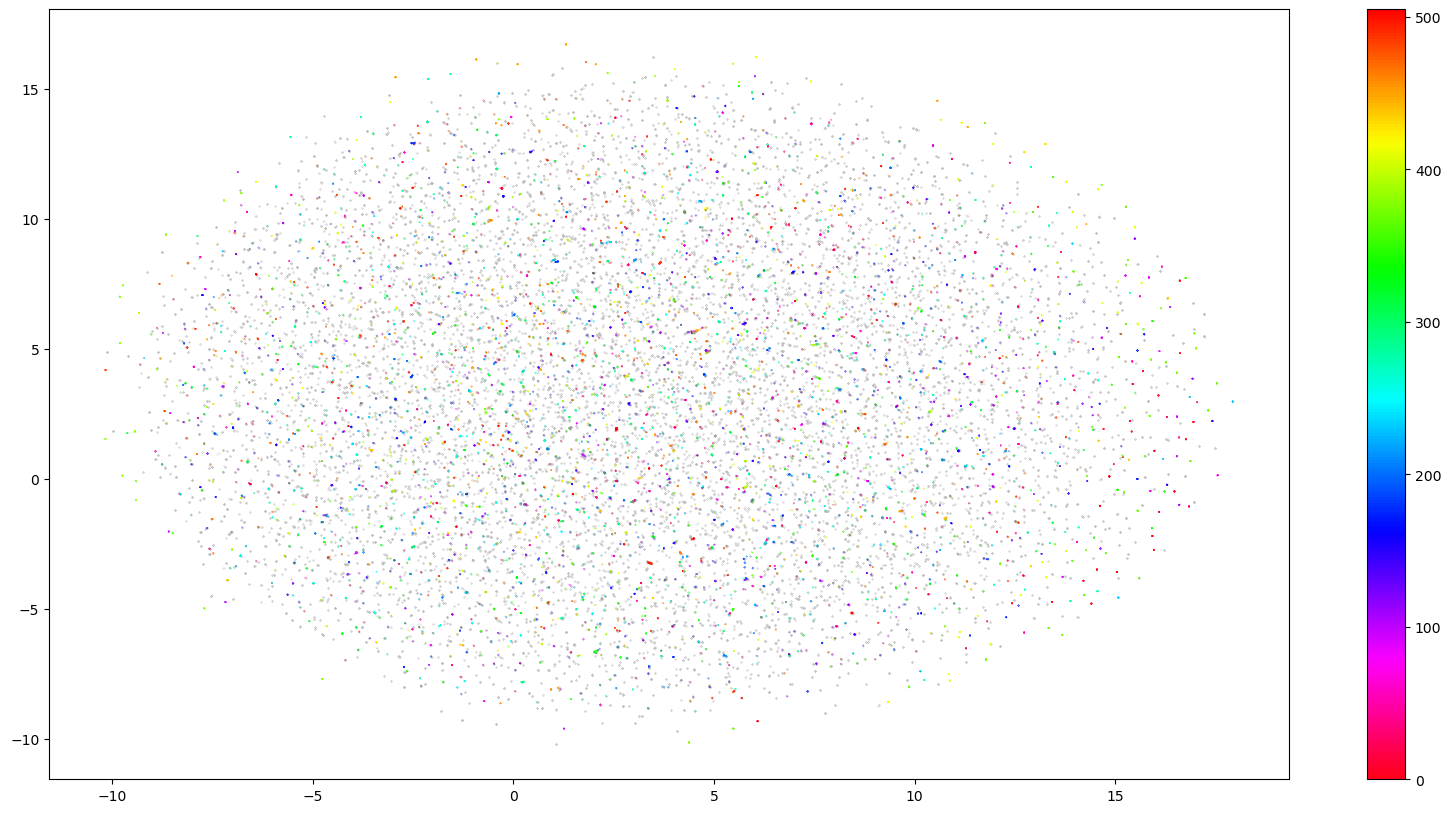


done with plot
test01-1
n_neighbers: 2
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  35960
208    207    142
250    249    123
505    504    116
481    480     98
412    411     97
274    273     97
465    464     93
449    448     88
333    332     85
507
142 [('f0', 0.30831474814760873), ('f2', 0.28209653110850896), ('f4', 0.21679567032915165), ('ptr_addu', 0.20248139440739624), ('f6', 0.20112098013598445), ('0x0', 0.18791051718754426), ('f28', 0.15353090469076416), ('f24', 0.15306749473121856), ('f8', 0.144601078628684), ('ppred', 0.14376546940236778)]
123 [('fname', 0.057951864618698085), ('size_t', 0.05118120300005093), ('read', 0.05062242541980377), ('rsize', 0.04468853157134302), ('frame', 0.04468656367785029), ('zstd', 0.043363833176412285), ('size', 0.04135372501919726), ('toread', 0.040760429305019885), ('cbuff', 0.040574506915477995), ('header', 0.03920221900031546)]
116 [('rp', 0.22519779927277692), ('pix1', 0.16670443761

/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


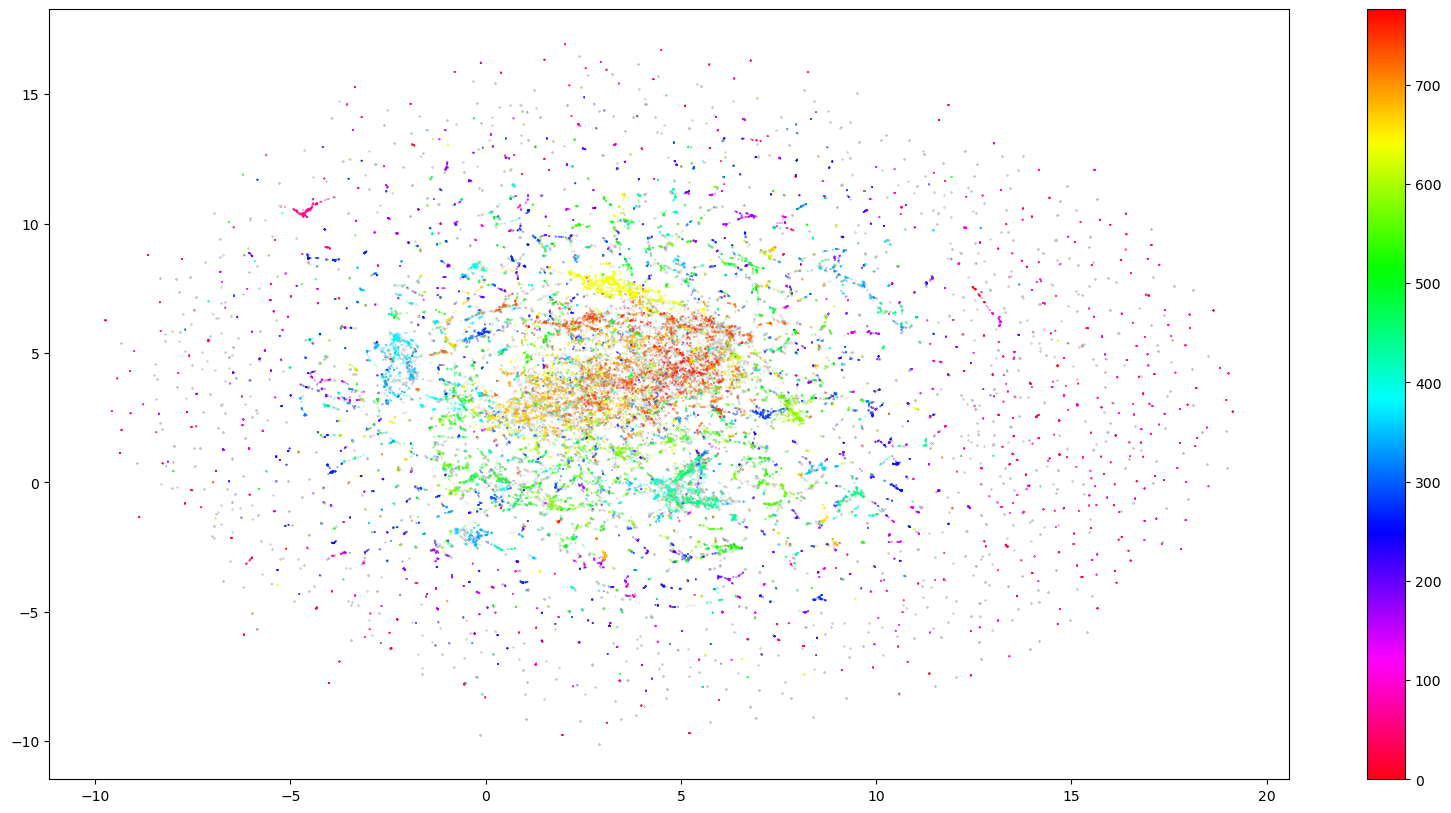


done with plot
test01-2
n_neighbers: 3
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  18300
639    638   1211
280    279    411
598    597    294
679    678    257
163    162    244
395    394    239
749    748    226
268    267    221
198    197    202
778
1211 [('pix1', 0.11732602477232629), ('rp', 0.10404384300374656), ('pix2', 0.08772526505245806), ('pixs', 0.08199088021632338), ('pixdestroy', 0.0784681821744287), ('pixa', 0.06824303437284276), ('lept', 0.06299568136201407), ('pix3', 0.060813726782145854), ('pixd', 0.058763322806845514), ('pixaaddpix', 0.05874364580530104)]
411 [('const', 0.0641544122147339), ('char', 0.05705047842335939), ('int', 0.04808934386371957), ('nullptr', 0.03883894028069758), ('poopeninfo', 0.03587461614898083), ('void', 0.03296106675903512), ('static', 0.032526796264704526), ('double', 0.032296822516476635), ('bool', 0.03223656365640036), ('return', 0.02993570910570935)]
294 [('size_t', 0.12065228060071

/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spe

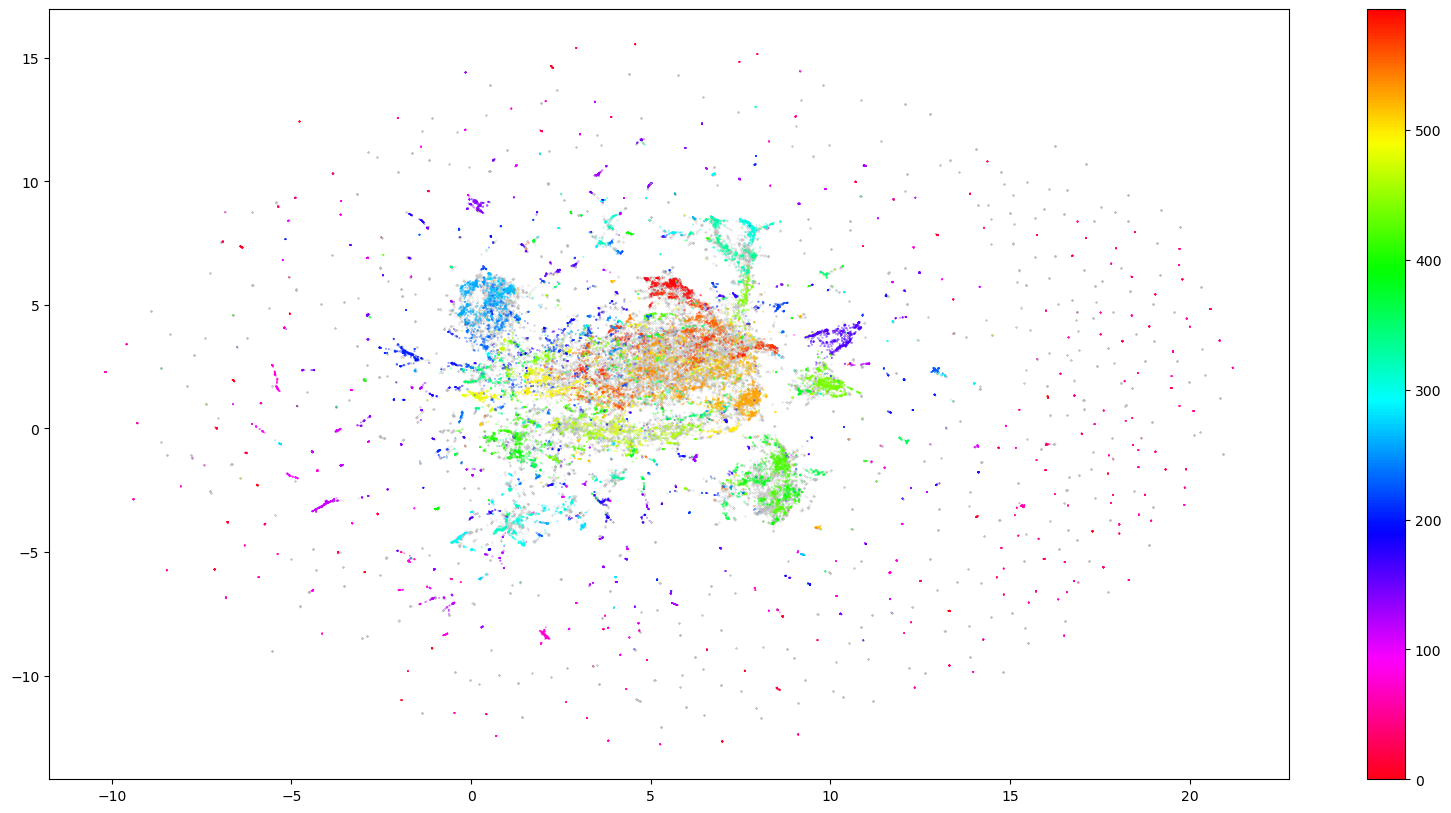


done with plot
test01-3
n_neighbers: 5
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  23705
162    161    684
439    438    614
528    527    479
420    419    476
486    485    328
139    138    308
305    304    294
266    265    287
217    216    271
595
684 [('nullptr', 0.05516071837077526), ('return', 0.044987828704680544), ('const', 0.040266876749718225), ('pods', 0.03800953852670355), ('poopeninfo', 0.03396710592945931), ('open', 0.03387823785429351), ('char', 0.03255489684998674), ('int', 0.03245591577648008), ('bool', 0.02975943209460852), ('gdaldataset', 0.025090606621436397)]
614 [('const', 0.10141176079595701), ('char', 0.08570355184674318), ('size_t', 0.08442504054820477), ('l_int32', 0.07724688223561496), ('int', 0.07522696773623917), ('unsigned', 0.07392155387575113), ('static', 0.07091661369113098), ('void', 0.048893523424337865), ('struct', 0.04158124819657978), ('pix', 0.038494552527909794)]
479 [('pctx', 0.083157435

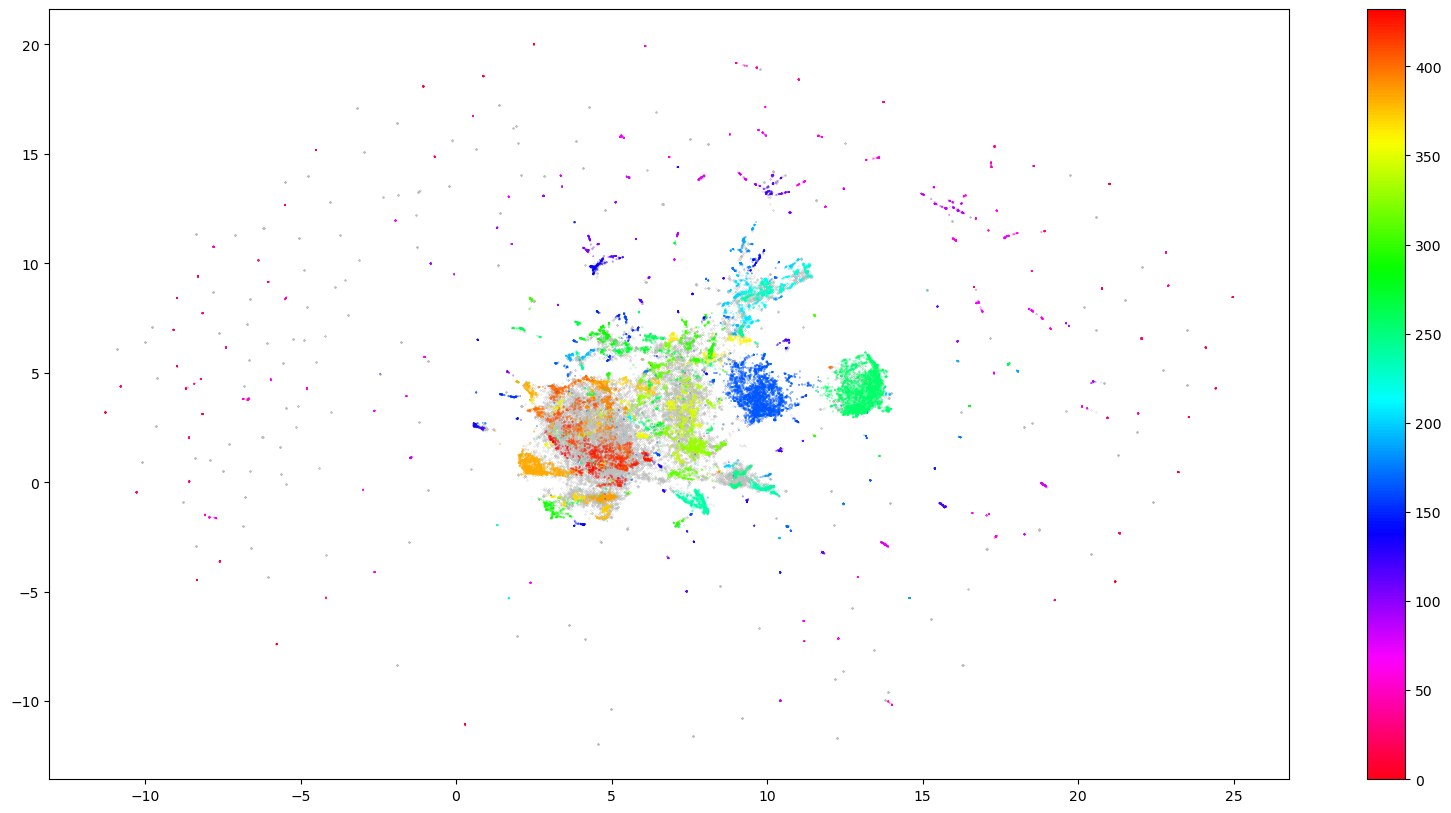


done with plot
test01-4
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  22209
165    164   3641
257    256   3356
384    383   1165
238    237    639
331    330    533
392    391    318
236    235    310
386    385    276
76      75    248
434
3641 [('struct', 0.07407344496425701), ('sizeof', 0.06251881701815443), ('stcb', 0.05503491131281), ('asoc', 0.044361864996967745), ('addr', 0.03893686592055663), ('inp', 0.03724182167017118), ('null', 0.03720167964322502), ('endif', 0.035105443951250564), ('net', 0.03465878003228755), ('perror', 0.03339180546265689)]
3356 [('return', 0.08361634750091232), ('null', 0.03254896301236638), ('ctx', 0.021307065667364938), ('ret', 0.021080042899104735), ('void', 0.02095350808991211), ('const', 0.019623861654692314), ('stderr', 0.019358477099757593), ('fprintf', 0.01918495550532172), ('size', 0.01619560245869831), ('size_t', 0.015870361370815995)]
1165 [('pix1', 0.12094111178741064), ('r

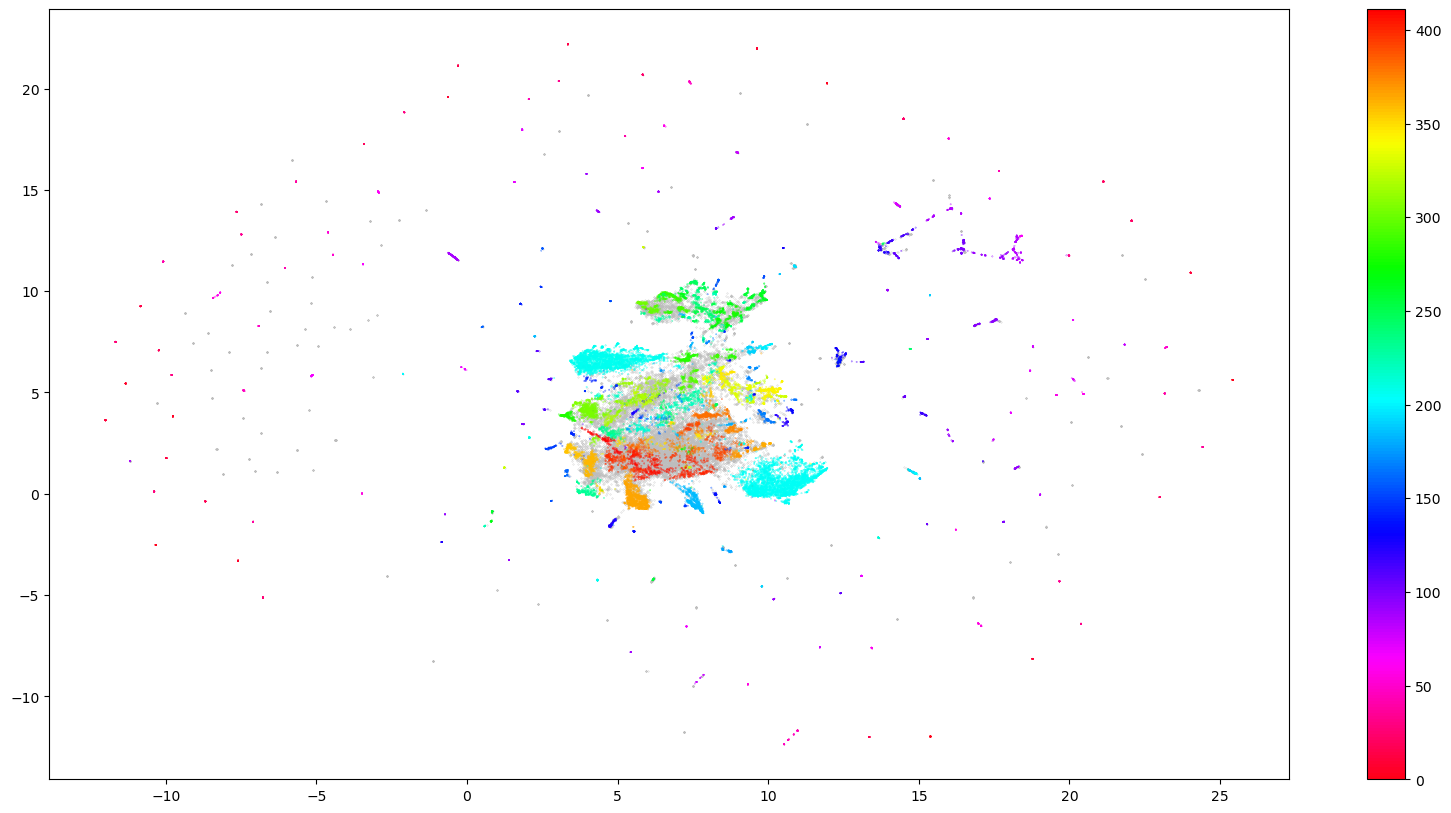


done with plot
test01-5
n_neighbers: 15
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  22321
206    205   3911
207    206   3595
366    365   1163
185    184    643
306    305    568
343    342    358
361    360    341
287    286    289
380    379    279
413
3911 [('return', 0.07579504219492758), ('null', 0.028256497644313226), ('doc', 0.024912872853308413), ('void', 0.021279693423583147), ('std', 0.020359009412757225), ('const', 0.018988135353558377), ('stderr', 0.01861158243142345), ('ctx', 0.018557264147928573), ('ret', 0.01850584280946011), ('fprintf', 0.018082943413171994)]
3595 [('struct', 0.07342130238276362), ('sizeof', 0.06345439582209743), ('stcb', 0.055651458622089936), ('asoc', 0.04485884387539385), ('addr', 0.039583245929048494), ('inp', 0.03780585469515565), ('null', 0.03746427015904497), ('endif', 0.03607775024639061), ('net', 0.03541753308928835), ('perror', 0.03458944677519861)]
1163 [('pix1', 0.12393403409408933), ('

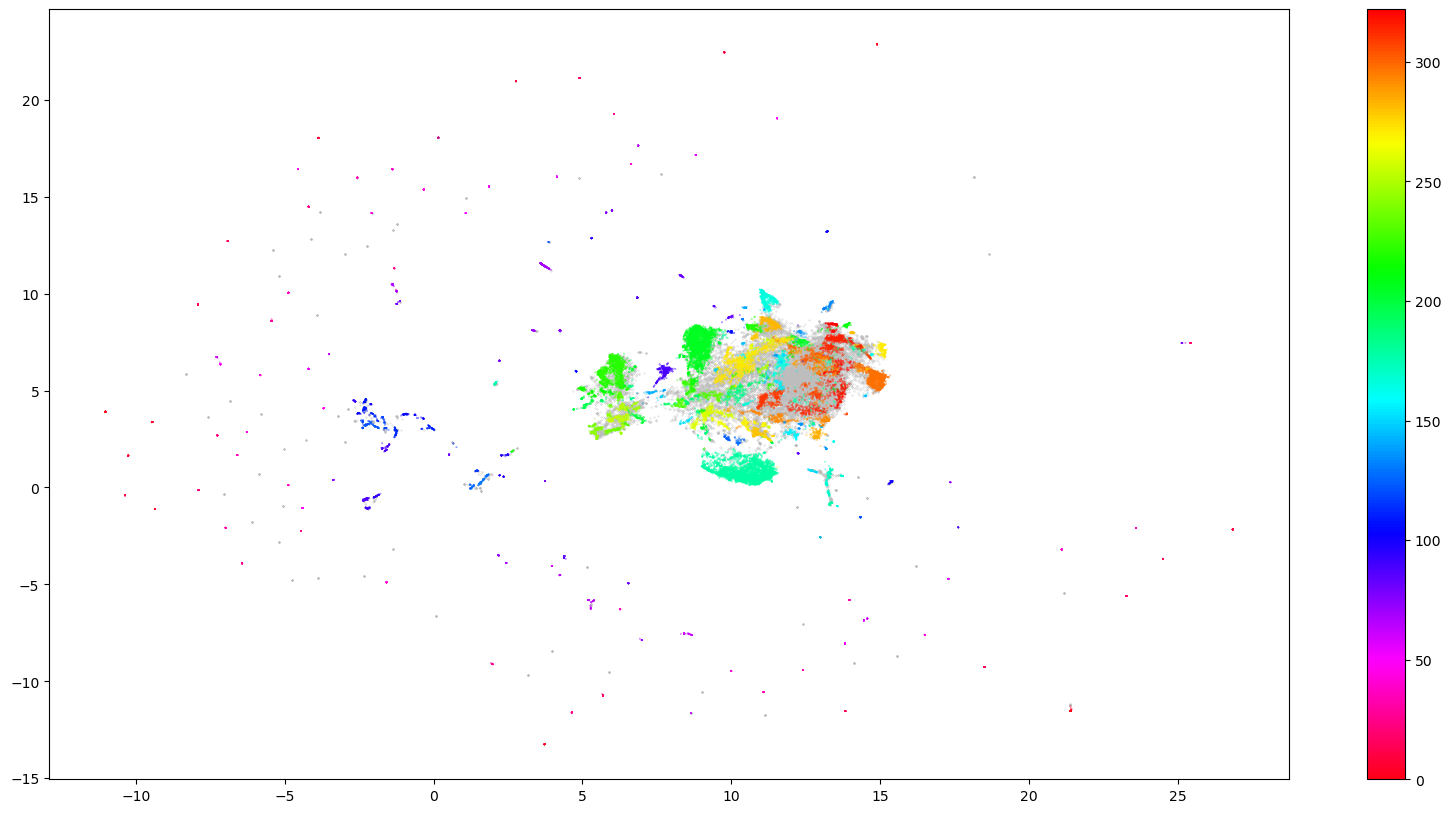


done with plot
test01-6
n_neighbers: 30
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  23274
179    178   3865
207    206   2890
222    221   1653
298    297   1053
273    272    989
166    165    604
90      89    393
316    315    337
283    282    332
324
3865 [('return', 0.07545718743188094), ('null', 0.02824912326224174), ('doc', 0.024650418205011716), ('std', 0.02165071664345512), ('void', 0.02121917665416903), ('stderr', 0.018628161499105053), ('ctx', 0.018573794829262493), ('int', 0.018414239172993518), ('ret', 0.01838907352901738), ('const', 0.018385319965477123)]
2890 [('struct', 0.07977864081070649), ('sizeof', 0.07124653875796857), ('stcb', 0.06196021776582789), ('asoc', 0.048934496967503315), ('addr', 0.04239623779701683), ('net', 0.03895981126288981), ('null', 0.037550729175928735), ('perror', 0.036529381494202234), ('inp', 0.03625194807249473), ('endif', 0.032755896603382705)]
1653 [('param', 0.07422962822413251), ('ret

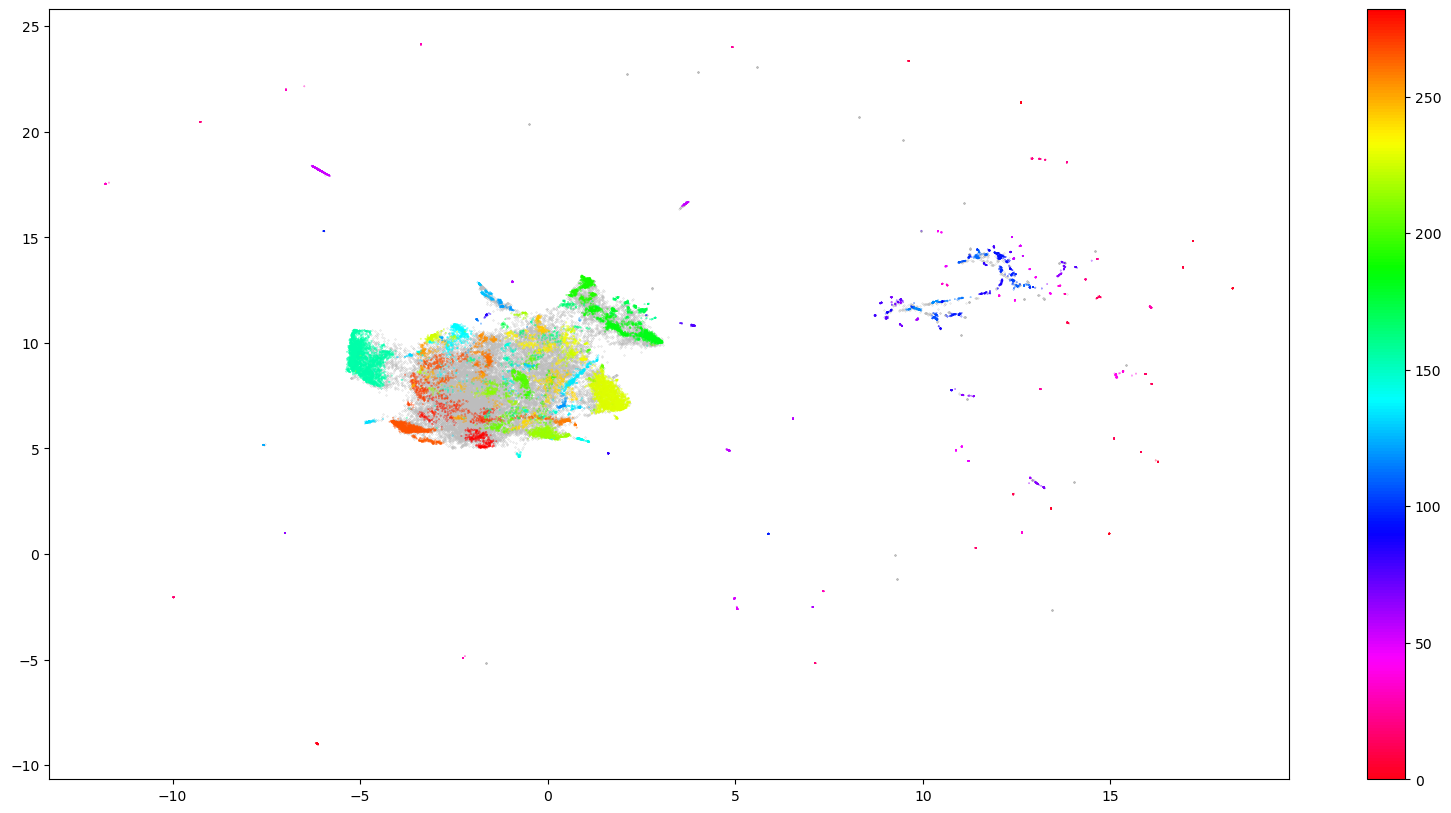


done with plot
test01-7
n_neighbers: 124
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  27620
156    155   3337
228    227   2584
267    266    881
216    215    817
183    182    790
139    138    568
185    184    479
191    190    445
54      53    423
284
3337 [('return', 0.0830345987807983), ('null', 0.029920622975168062), ('doc', 0.023887856080032178), ('void', 0.022762204520521353), ('const', 0.019965758730683413), ('ctx', 0.019408068878579505), ('ret', 0.01931864468765978), ('stderr', 0.018819755866234637), ('fprintf', 0.018582814679798523), ('int', 0.018236236598186992)]
2584 [('struct', 0.08808506750380733), ('sizeof', 0.07601385231083001), ('stcb', 0.06243518191959449), ('asoc', 0.04863619880136097), ('addr', 0.04779402843983263), ('perror', 0.04155950308005316), ('null', 0.038191727846985914), ('sock', 0.03763192218092481), ('inp', 0.0367505694757406), ('net', 0.03661342224187076)]
881 [('pix1', 0.13742281660431924), ('rp'

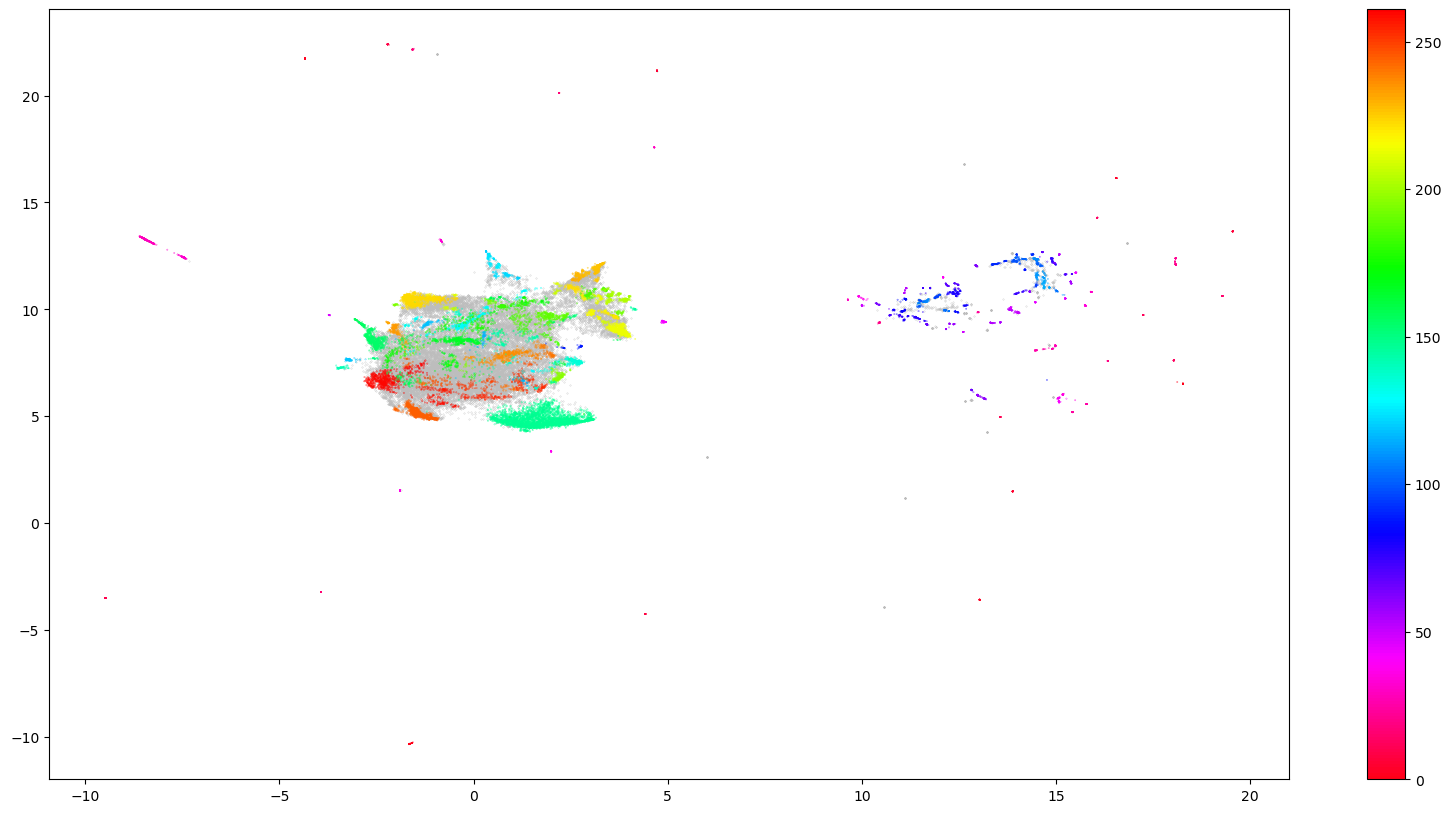


done with plot
test01-8
n_neighbers: 256
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  30342
148    147   3703
224    223   1098
215    214    752
245    244    709
155    154    655
260    259    598
30      29    421
228    227    383
130    129    371
263
3703 [('return', 0.07779970773568133), ('null', 0.028512585543558643), ('doc', 0.02472921821306538), ('void', 0.021586415094476424), ('std', 0.020694148199839908), ('const', 0.018739550692635953), ('stderr', 0.018724520905739377), ('ctx', 0.018545122670624675), ('int', 0.018443854535851633), ('fprintf', 0.018426425438289047)]
1098 [('struct', 0.11012391752587258), ('sizeof', 0.0972077903904508), ('stcb', 0.0701313652346835), ('perror', 0.05209439781225184), ('sock', 0.051810472132312296), ('asoc', 0.051075979984926446), ('addr', 0.05002552326066336), ('sockaddr', 0.04261274476273897), ('inp', 0.0418961452932135), ('usrsctp_setsockopt', 0.041577178733818755)]
752 [('used', 0.03198

In [7]:
# n_neighbors       : number of approximate nearest neighbors used to construct the initial high-dimensional graph
#                       * low values allows concentration on local structure
#                       * high values allows concentration on global structure (lost details)
# n_components      : reduced dimension size
# min_dist          : minimum distance between point in low-dimensional space

# min_cluster_size  : fixes the minimum size a cluster can contain
# min_samples       : the minimum number of points required to form a dense region (core points)

# title

chng_neigh = [
    [2, 90, 0.0, 15, 15, 'test01-1'],
    [3, 90, 0.0, 15, 15, 'test01-2'],
    [5, 90, 0.0, 15, 15, 'test01-3'],
    [10, 90, 0.0, 15, 15, 'test01-4'],
    [15, 90, 0.0, 15, 15, 'test01-5'],
    [30, 90, 0.0, 15, 15, 'test01-6'],
    [124, 90, 0.0, 15, 15, 'test01-7'],
    [256, 90, 0.0, 15, 15, 'test01-8'],
]

for i in range(len(chng_neigh)):
  docs_per_topic, top_n_words, topic_sizes = plot(embeddings.numpy(),
                                                  data_list,
                                                  chng_neigh[i][0],
                                                  chng_neigh[i][1],
                                                  chng_neigh[i][2],
                                                  chng_neigh[i][3],
                                                  chng_neigh[i][4],
                                                  chng_neigh[i][5])
  write_results(topic_sizes, top_n_words, chng_neigh[i])


done with reducing dimension

done with clustering


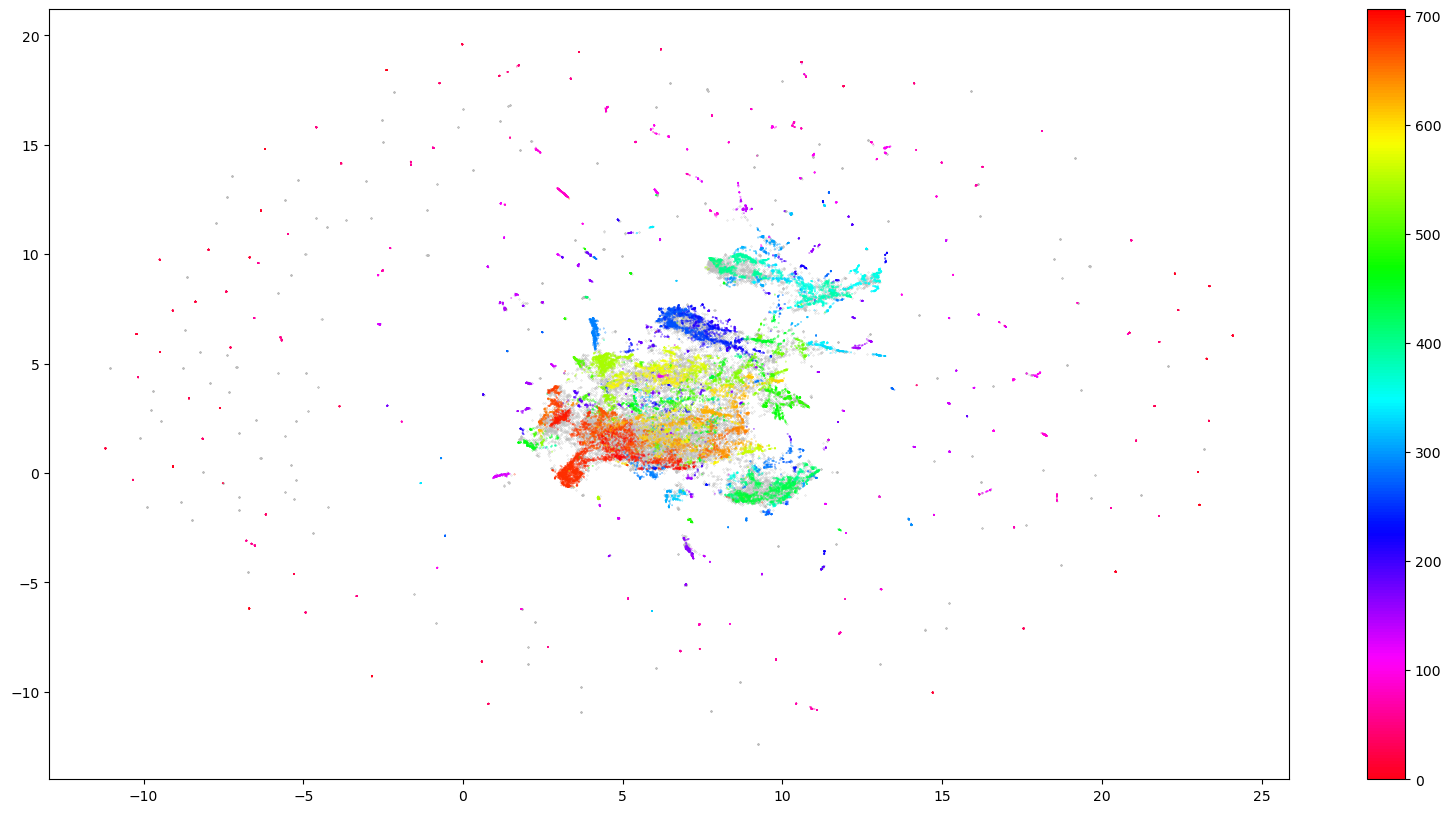


done with plot


/tmp/ipykernel_558053/3933380912.py:5: RuntimeWarning: invalid value encountered in divide
  tf = np.divide(t.T, w)


test02-1
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 5
     Topic   Size
0       -1  21894
684    683   1152
289    288    673
545    544    672
695    694    310
623    622    301
390    389    291
126    125    272
440    439    264
268    267    260
708
1152 [('pix1', 0.12369057650402333), ('rp', 0.11000334164683719), ('pix2', 0.09248353321065585), ('pixs', 0.0861260319267645), ('pixdestroy', 0.07742055656812954), ('pixa', 0.07100361742542394), ('lept', 0.0689112163067417), ('pixd', 0.06688110270677443), ('pixaaddpix', 0.06161181943513759), ('regtestwritepixandcheck', 0.06093270766909337)]
673 [('nullptr', 0.06107711458736804), ('pods', 0.049382210408627926), ('return', 0.04839848615014088), ('poopeninfo', 0.038613976448358976), ('sptr', 0.03821388234920639), ('open', 0.03720136421573268), ('const', 0.03144737657399437), ('int', 0.0304982165762907), ('gdaldataset', 0.028123643919339594), ('bool', 0.025309220473152965)]
672 [('const', 0.1089265688

/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


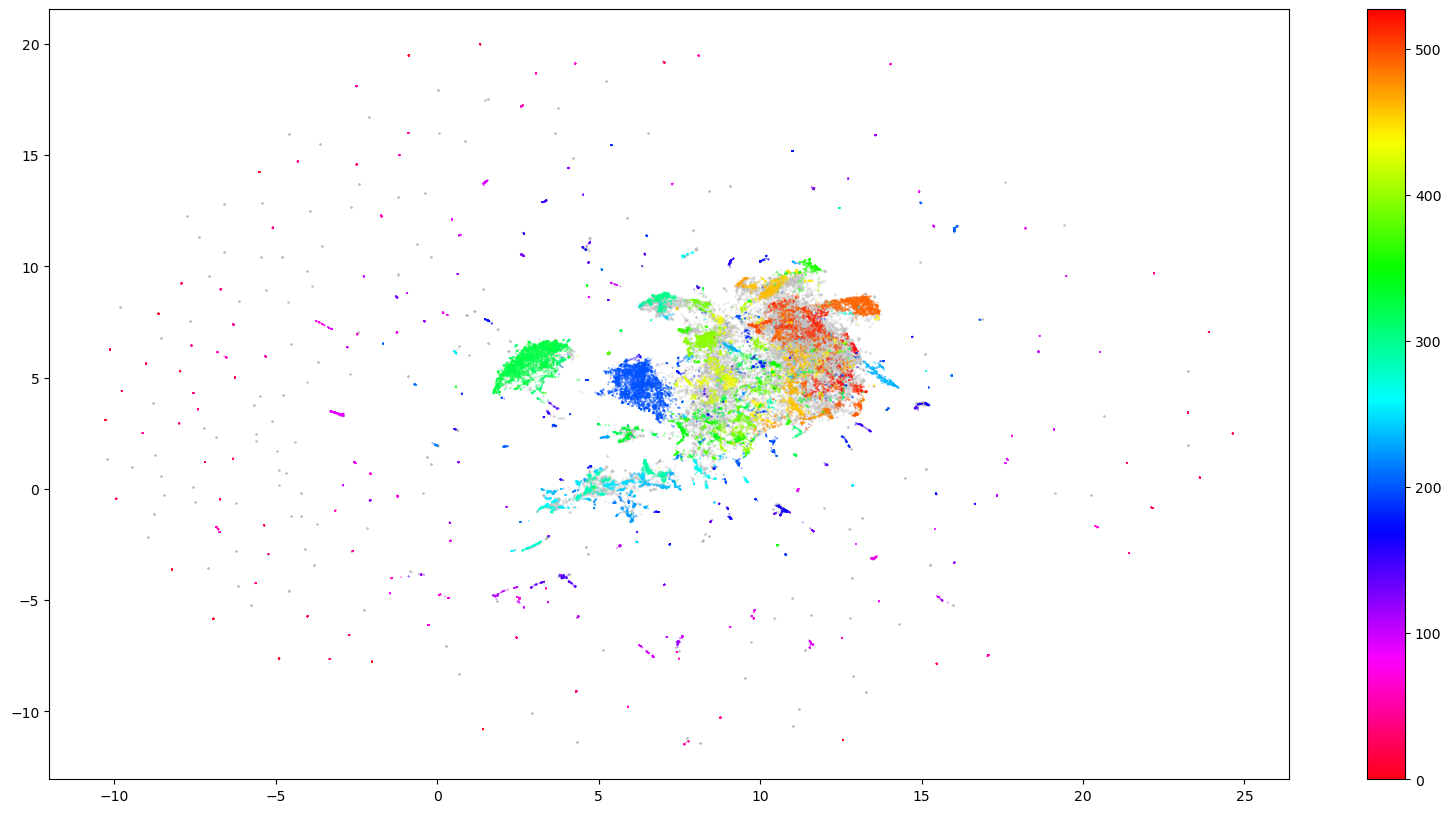


done with plot


/tmp/ipykernel_558053/3933380912.py:5: RuntimeWarning: invalid value encountered in divide
  tf = np.divide(t.T, w)


test02-2
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 10
     Topic   Size
0       -1  20512
200    199   3650
325    324   3266
493    492   1151
235    234    642
398    397    597
462    461    407
458    457    328
292    291    321
361    360    254
529
3650 [('struct', 0.07369940538091571), ('sizeof', 0.06276465837131609), ('stcb', 0.05571593072494801), ('asoc', 0.044688040704247936), ('addr', 0.03863925932542824), ('null', 0.03723277106522038), ('inp', 0.03714953908846917), ('endif', 0.03592329996813119), ('net', 0.03537277890622576), ('perror', 0.03337411971048361)]
3266 [('return', 0.08346648707911448), ('null', 0.033550703072434546), ('ret', 0.02156604820369645), ('ctx', 0.02131922140767839), ('void', 0.021015953464421464), ('stderr', 0.02067658763192855), ('fprintf', 0.020379887654322824), ('const', 0.01900825723672481), ('error', 0.016139832138147615), ('size_t', 0.016026298222254112)]
1151 [('pix1', 0.1224177380420287), ('rp', 0.10790647

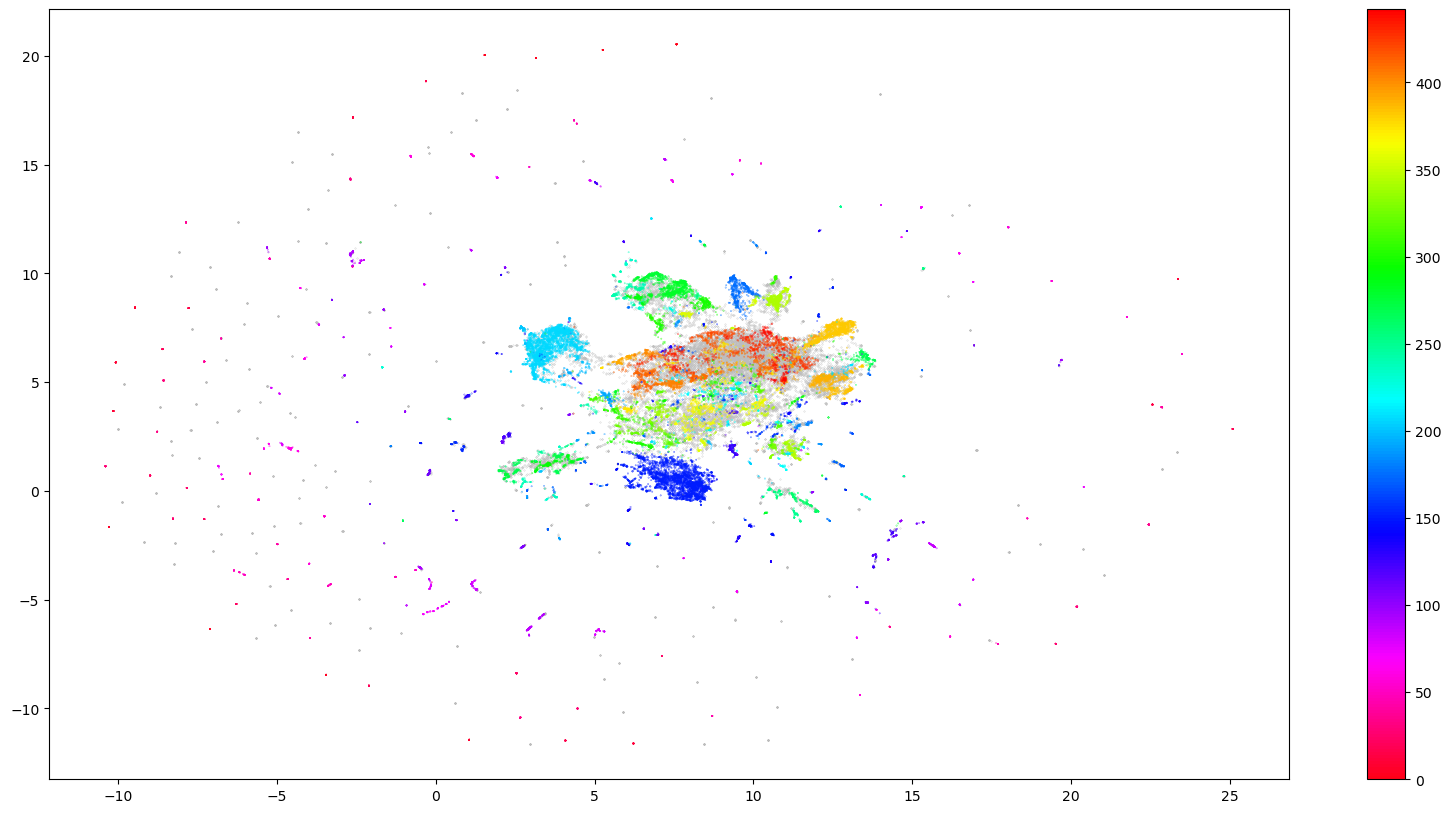


done with plot
test02-3
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 15
     Topic   Size
0       -1  20948
152    151   3585
208    207   3035
383    382   1223
281    280    790
176    175    651
344    343    588
390    389    386
278    277    329
405    404    301
444
3585 [('struct', 0.07432524875442761), ('sizeof', 0.06395733812296081), ('stcb', 0.05627897732113637), ('asoc', 0.04483427281634318), ('addr', 0.0384832937115955), ('inp', 0.037817354892208395), ('null', 0.03777659251241505), ('net', 0.03586405585389687), ('endif', 0.03506650184836506), ('perror', 0.033907840729614724)]
3035 [('return', 0.08447144206843706), ('null', 0.03312896471107954), ('ret', 0.022347622521998404), ('ctx', 0.02209185048561853), ('const', 0.020007752769764978), ('void', 0.019940471805913386), ('stderr', 0.019893016959524397), ('fprintf', 0.019669371333481747), ('size', 0.01613282165774976), ('error', 0.016094445758463825)]
1223 [('pix1', 0.12132335814428151), (

/home/arise/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


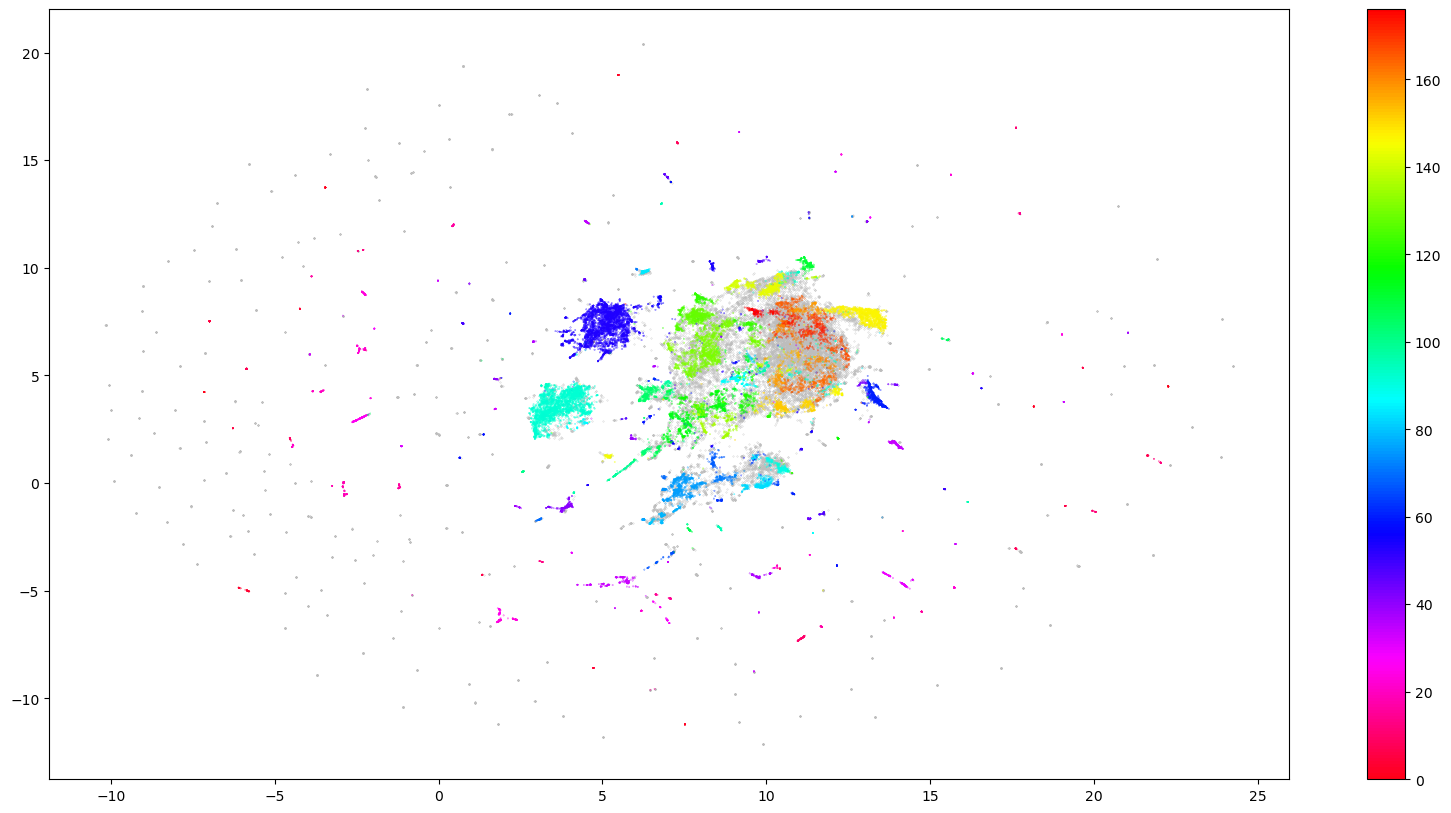


done with plot
test02-4
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 30
     Topic   Size
0       -1  23553
54      53   3699
93      92   3360
132    131   1321
148    147   1161
76      75    729
61      60    663
129    128    609
144    143    410
105    104    395
178
3699 [('struct', 0.073183589984644), ('sizeof', 0.06218944983388091), ('stcb', 0.054602351726233275), ('asoc', 0.04391221604170638), ('addr', 0.03863371675450282), ('inp', 0.03697681311546608), ('null', 0.036576072700173545), ('endif', 0.035714236282890374), ('net', 0.03486780800346448), ('perror', 0.03377300737623372)]
3360 [('return', 0.0824318880798971), ('null', 0.03219162883950169), ('ret', 0.021180455350378973), ('void', 0.020708951270013275), ('ctx', 0.020626695379547172), ('const', 0.019977616541746207), ('stderr', 0.01948078987860515), ('fprintf', 0.018965921765410867), ('size', 0.016151761441440385), ('error', 0.01584296249933493)]
1321 [('static', 0.08002930685713533), 

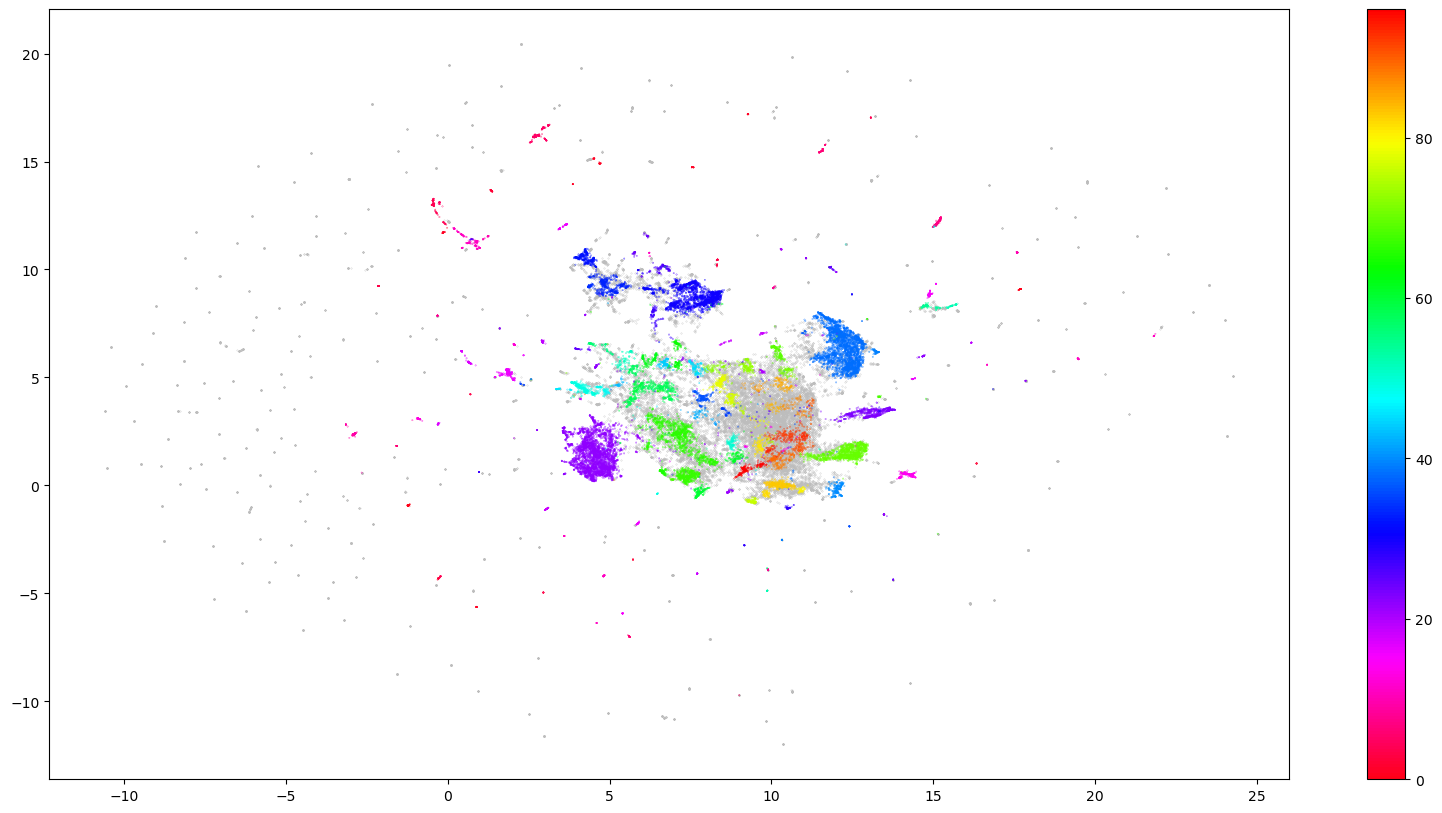


done with plot
test02-5
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 60
    Topic   Size
0      -1  26422
23     22   3716
39     38   3023
31     30   1910
71     70   1243
67     66   1122
24     23    649
68     67    500
59     58    476
34     33    472
98
3716 [('struct', 0.07231333367340996), ('sizeof', 0.06210673512779362), ('stcb', 0.0546693335200449), ('asoc', 0.04400347015875589), ('addr', 0.039362622967853096), ('inp', 0.036551737892203603), ('null', 0.0364910872111489), ('endif', 0.035337141103720784), ('net', 0.03430926294476579), ('perror', 0.033507088749870795)]
3023 [('return', 0.08447797021189682), ('null', 0.03288898865349631), ('ret', 0.02212679669290754), ('ctx', 0.021617221354692767), ('void', 0.021031742086089537), ('const', 0.018848213790956848), ('stderr', 0.01802831409158758), ('fprintf', 0.01760941359081716), ('size_t', 0.016879825816887174), ('size', 0.016617495753483893)]
1910 [('param', 0.06505704887210526), ('returns',

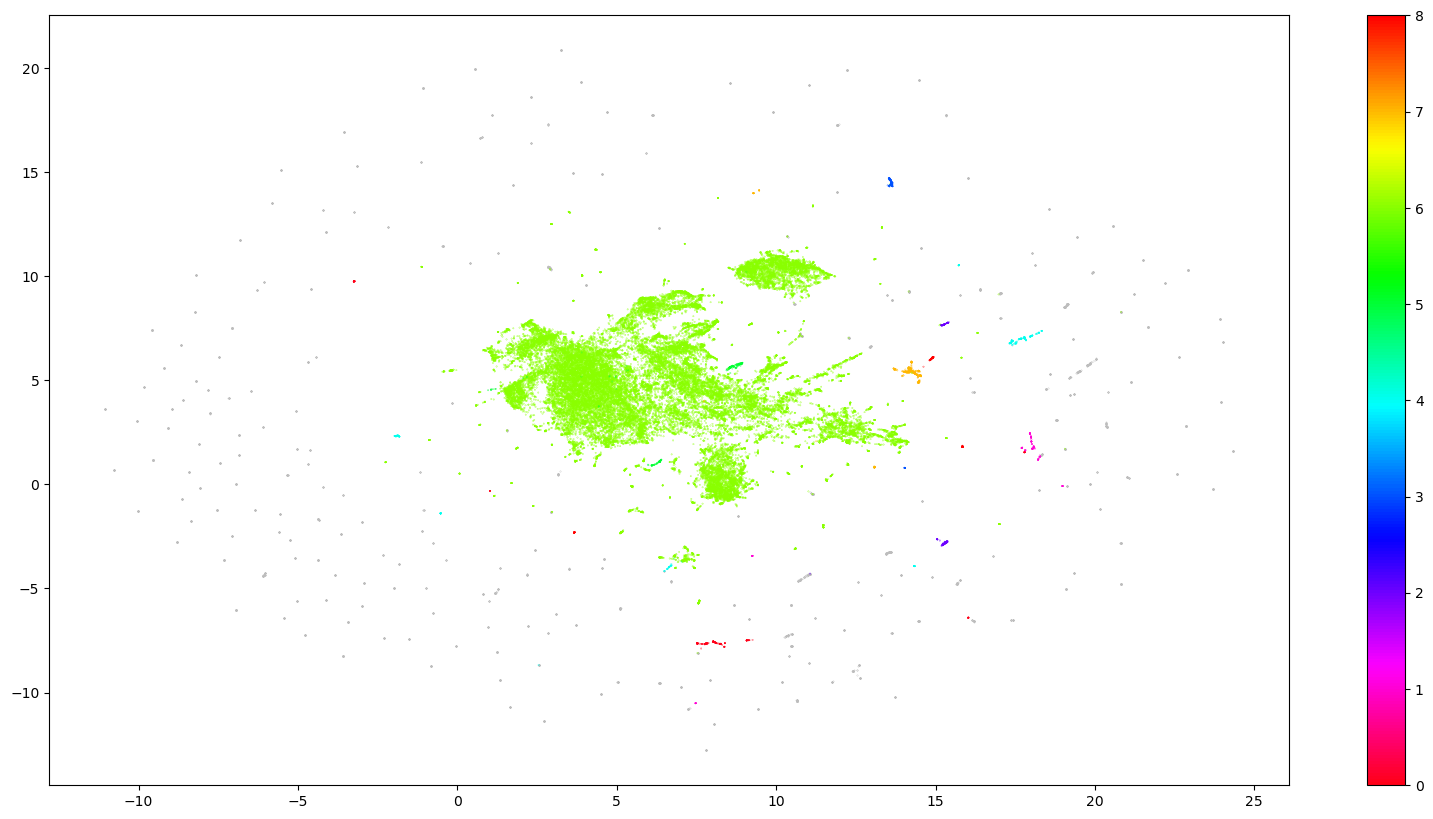


done with plot
test02-6
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 120
   Topic   Size
7      6  43802
0     -1   4034
8      7    431
5      4    319
3      2    302
6      5    271
4      3    248
1      0    236
9      8    161
2      1    124
10
43802 [('return', 0.02355557849265582), ('null', 0.022397045697340717), ('const', 0.021347712639639083), ('int', 0.019607261008526115), ('include', 0.019572294981049572), ('void', 0.019394685959324594), ('char', 0.016137416650808773), ('size_t', 0.013500651886491664), ('struct', 0.013428893375524272), ('static', 0.013170527136991395)]
431 [('argc', 0.2902168041741852), ('argv', 0.24670171216229425), ('main', 0.22271526128670294), ('int', 0.2061837439739234), ('char', 0.15802362002587697), ('attribute_unused', 0.06950744417616653), ('qapplication', 0.06773452743933998), ('include', 0.06409562284527277), ('const', 0.052659705783759454), ('qcoreapplication', 0.04342204812671262)]
319 [('copyright', 0.1365

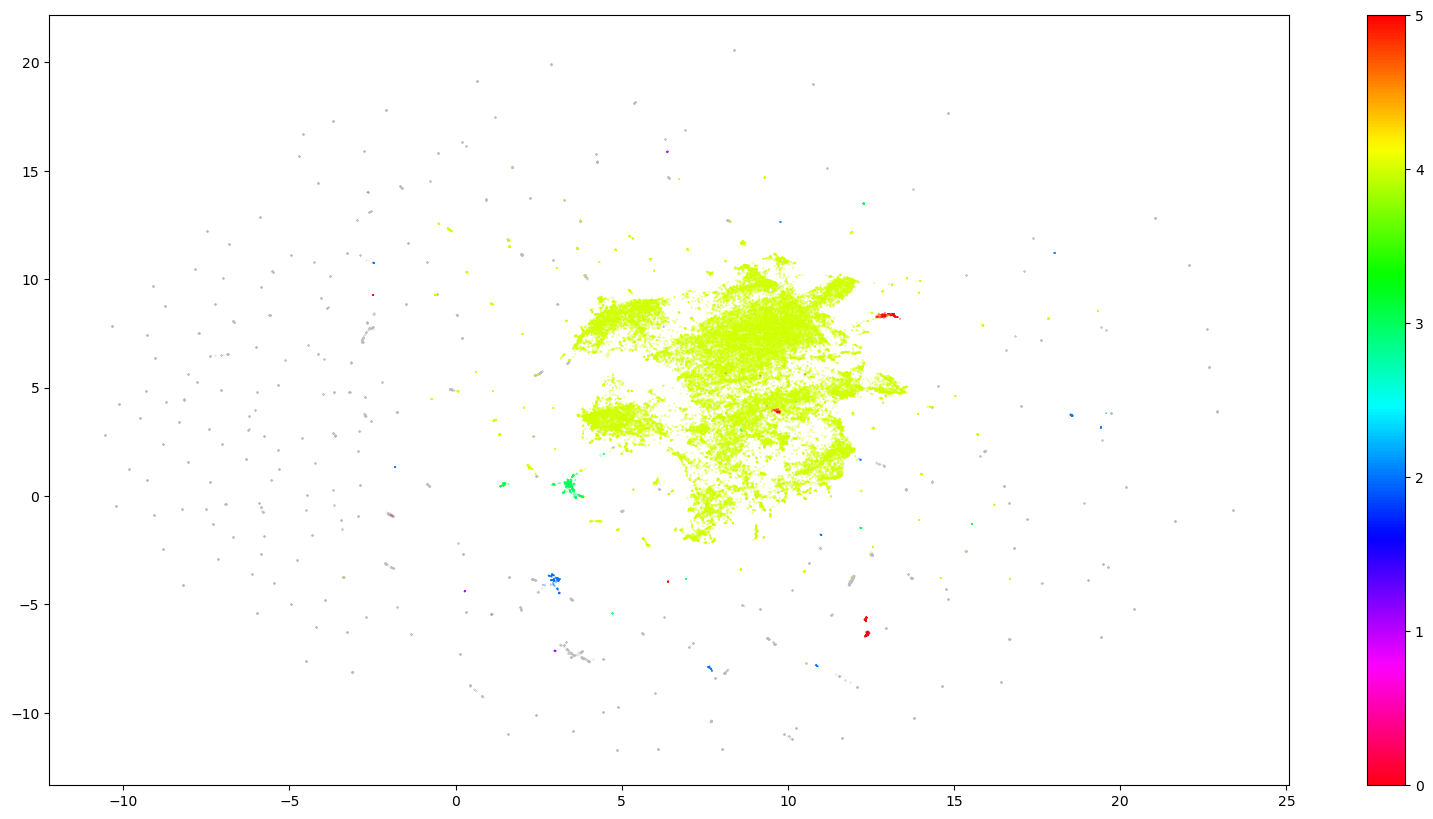


done with plot
test02-7
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 256
   Topic   Size
5      4  43575
0     -1   4805
4      3    637
3      2    315
1      0    301
6      5    267
2      1     28
7
43575 [('return', 0.02362804884199542), ('null', 0.02247122055986096), ('const', 0.021321250203108325), ('int', 0.01970301899620081), ('include', 0.019549212515276467), ('void', 0.019020716365612016), ('char', 0.016332027604677928), ('size_t', 0.013581605317631383), ('struct', 0.013502339825887905), ('static', 0.013242360390538777)]
637 [('argc', 0.26231224340135056), ('main', 0.22199936307333631), ('argv', 0.21695290518326454), ('int', 0.1946279213583403), ('char', 0.15317084910762288), ('include', 0.059468076846640225), ('l_int32', 0.045696356921924), ('attribute_unused', 0.045597695219348755), ('qapplication', 0.04553179276540717), ('const', 0.043965079500138234)]
315 [('copyright', 0.1424805175672384), ('source', 0.09627948504819737), ('software'

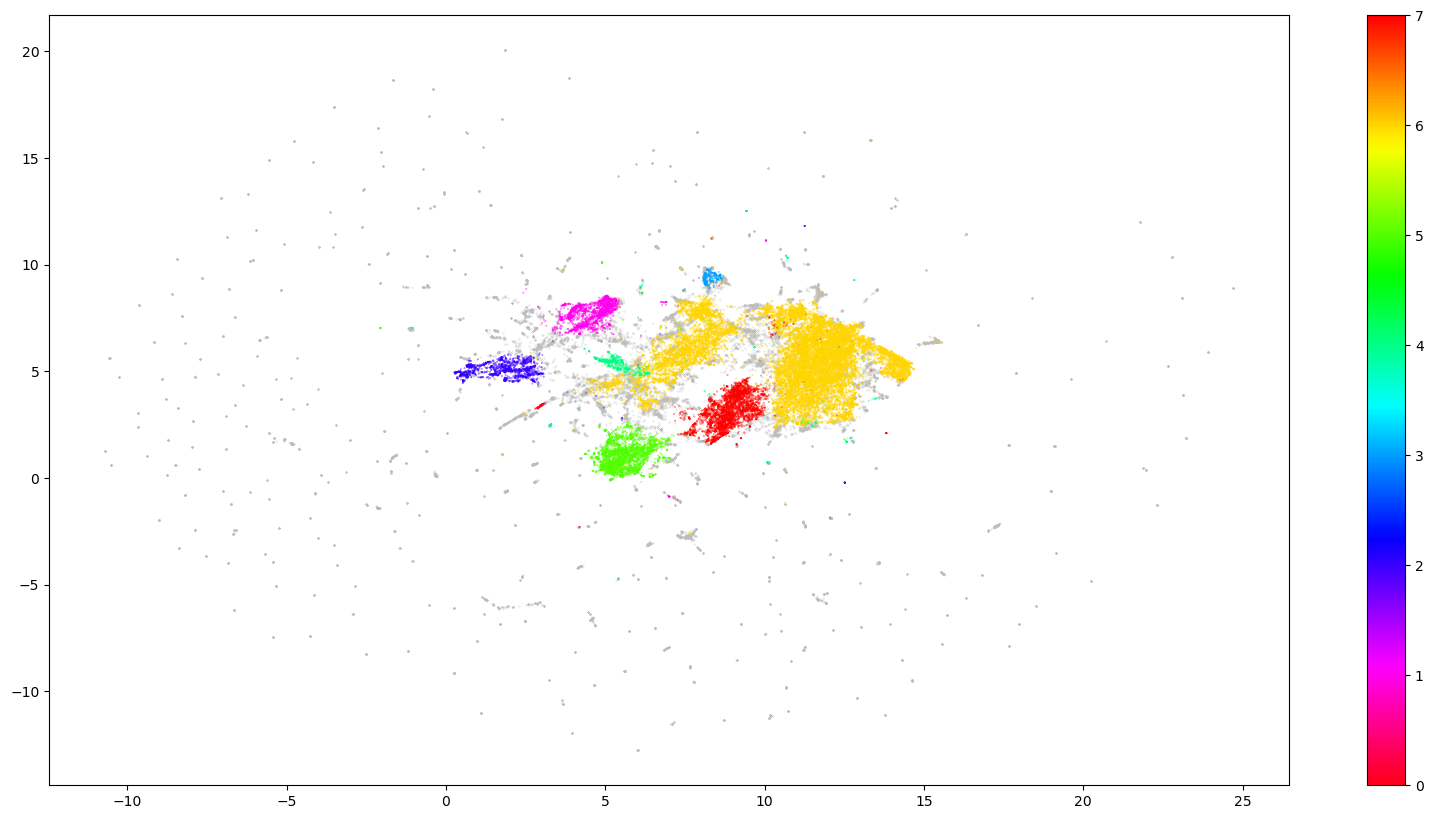


done with plot
test02-8
n_neighbers: 10
n_components: 90
min_dist: 0.0
min_cluster_size: 15
min_samples: 512
   Topic   Size
7      6  19594
0     -1  18346
8      7   3580
6      5   3431
2      1   2108
3      2   1592
5      4    855
4      3    339
1      0     83
9
19594 [('null', 0.028598758856303204), ('const', 0.028213664351067626), ('return', 0.026418477357941776), ('int', 0.024724323899367243), ('size_t', 0.021710671720308206), ('char', 0.02144118236058945), ('void', 0.020050674426972597), ('static', 0.016201910741330833), ('unsigned', 0.015902681767304822), ('size', 0.015639718307739206)]
3580 [('return', 0.07757953491639108), ('null', 0.029623600244092385), ('const', 0.020609877365396), ('void', 0.02029734879165686), ('stderr', 0.019948197472604515), ('ret', 0.01962081872672204), ('fprintf', 0.01953301225414268), ('ctx', 0.018338277819895405), ('std', 0.018184265166091784), ('int', 0.016816122347407838)]
3431 [('struct', 0.07461299475750295), ('sizeof', 0.06431292091493535

In [8]:
# n_neighbors       : number of approximate nearest neighbors used to construct the initial high-dimensional graph
#                       * low values allows concentration on local structure
#                       * high values allows concentration on global structure (lost details)
# n_components      : reduced dimension size
# min_dist          : minimum distance between point in low-dimensional space

# min_cluster_size  : fixes the minimum size a cluster can contain
# min_samples       : the minimum number of points required to form a dense region (core points)

# title

chng_neigh = [
    [10, 90, 0.0, 15, 5, 'test02-1'],
    [10, 90, 0.0, 15, 10, 'test02-2'],
    [10, 90, 0.0, 15, 15, 'test02-3'],
    [10, 90, 0.0, 15, 30, 'test02-4'],
    [10, 90, 0.0, 15, 60, 'test02-5'],
    [10, 90, 0.0, 15, 120, 'test02-6'],
    [10, 90, 0.0, 15, 256, 'test02-7'],
    [10, 90, 0.0, 15, 512, 'test02-8'],
]

for i in range(len(chng_neigh)):
  docs_per_topic, top_n_words, topic_sizes = plot(embeddings.numpy(),
                                                  data_list,
                                                  chng_neigh[i][0],
                                                  chng_neigh[i][1],
                                                  chng_neigh[i][2],
                                                  chng_neigh[i][3],
                                                  chng_neigh[i][4],
                                                  chng_neigh[i][5])
  write_results(topic_sizes, top_n_words, chng_neigh[i])